# Pyro Examples

In [1]:
import pandas as pd
import numpy as np
from orbit.models.lgt import LGTMAP, LGTAggregated, LGTFull
from orbit.estimators.pyro_estimator import PyroEstimatorVI, PyroEstimatorMAP
from orbit.diagnostics.plot import plot_predicted_data
from orbit.diagnostics.plot import plot_predicted_components
from orbit.utils.dataset import load_iclaims

In [2]:
pd.set_option('display.float_format', lambda x: '%.5f' % x)

## Data

In [4]:
df = load_iclaims()

date_col = 'week'
response_col = 'claims'
df.dtypes

week              datetime64[ns]
claims                     int64
trend.unemploy           float64
trend.filling            float64
trend.job                float64
dtype: object

In [5]:
df[['claims', 'trend.unemploy', 'trend.filling', 'trend.job']] =\
    df[['claims', 'trend.unemploy', 'trend.filling', 'trend.job']].apply(np.log)

### Train / Test Split

In [6]:
test_size=52
train_df=df[:-test_size]
test_df=df[-test_size:]

## MAP Fit and Predict

In [7]:
lgt_map = LGTMAP(
    response_col="claims",
    date_col="week",
    seasonality=52,
    seed=8888,
    estimator_type=PyroEstimatorMAP,
    learning_rate=0.3,
    num_steps=501,
)

In [8]:
%%time
lgt_map.fit(df=train_df)

CPU times: user 53.4 s, sys: 598 ms, total: 54 s
Wall time: 54.4 s


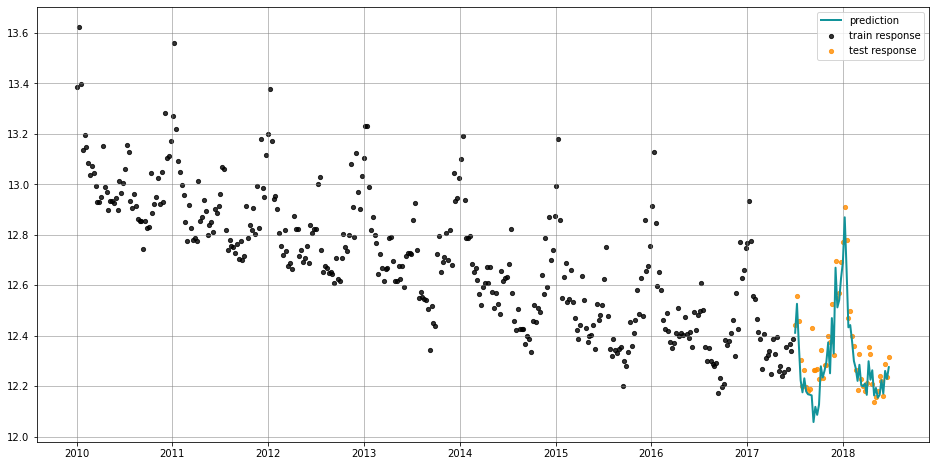

In [9]:
predicted_df = lgt_map.predict(df=test_df)
plot_predicted_data(training_actual_df=train_df, predicted_df=predicted_df, 
                    date_col=lgt_map.date_col, actual_col=lgt_map.response_col, 
                    test_actual_df=test_df)

## VI Fit and Predict

Pyro only support Variational Inference(SVI) for full sampling prediction.  Note that `pyro` takes advantage of parallel processing in `vi` and hence result in similar computation time compared to `map`.

In [10]:
lgt_vi = LGTFull(
    response_col='claims',
    date_col='week',
    seasonality=52,
    seed=8888,
    estimator_type=PyroEstimatorVI,
    num_steps=501,
    num_sample=100,
    learning_rate=0.1,
    learning_rate_total_decay=0.1,
    n_bootstrap_draws=-1,
    verbose=True,
)

In [11]:
%%time
lgt_vi.fit(df=train_df)

INFO:root:Guessed max_plate_nesting = 2


step    0 loss = 658.91, scale = 0.11666
step  100 loss = -445.76, scale = 0.34038
step  200 loss = -446.93, scale = 0.34647
step  300 loss = -448.52, scale = 0.34065
step  400 loss = -448.16, scale = 0.34905
step  500 loss = -448.03, scale = 0.34122
CPU times: user 4min 34s, sys: 3.61 s, total: 4min 38s
Wall time: 1min 10s


In [12]:
predicted_df = lgt_vi.predict(df=test_df)

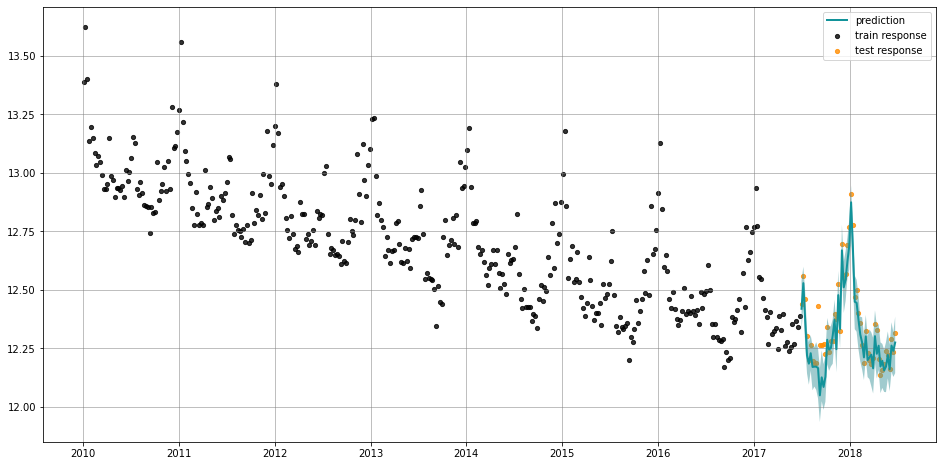

In [13]:
plot_predicted_data(training_actual_df=train_df, predicted_df=predicted_df, 
                    date_col=lgt_vi.date_col, actual_col=lgt_vi.response_col, 
                    test_actual_df=test_df)